In [20]:
import torch

from script.Networks import ICNN, SequentialNN
from torch.utils.data import DataLoader
from script.dataInit import ConvexDataset, Rhombus
from script.trainFunction import train_sequential_2
from script.eval import Plots_for
from script.Verification import verification
import matplotlib
import torchvision as tv
from script.testFunction import test_sequential

from matplotlib import pyplot as plt

def plot_2d(nn, included, ambient):
    included_out_x = []
    included_out_y = []
    for x in included:
        x = torch.unsqueeze(x, dim=0)
        out = nn(x)
        included_out_x.append(out[0][0].item())
        included_out_y.append(out[0][1].item())
    ambient_out_x = []
    ambient_out_y = []
    for x in ambient:
        x = torch.unsqueeze(x, dim=0)
        out = nn(x)
        ambient_out_x.append(out[0][0].item())
        ambient_out_y.append(out[0][1].item())

    plt.scatter(included_out_x, included_out_y)
    plt.scatter(ambient_out_x, ambient_out_y)
    plt.show()

In [21]:
epochs = 3
batch_size = 1
number_of_train_samples = 10000
hyper_lambda = 0.1
x_range = [-1.5, 1.5]
y_range = [-1.5, 1.5]
icnn = SequentialNN([2, 2, 2])
second_nn = SequentialNN([2, 2, 2])

In [22]:
true_extremal_points = [[0,0]]

#matplotlib.use('TkAgg')
ambient_space = torch.load("../../ambient_space_after_relu.pt", weights_only=True)
included_space = torch.load("../../included_space_after_relu.pt", weights_only=True)


mean tensor([1.0730, 1.0186], dtype=torch.float64, grad_fn=<DivBackward0>), mean_inc tensor([1.0731, 1.0187], dtype=torch.float64, grad_fn=<MeanBackward1>), mean_amb tensor([1.0730, 1.0186], dtype=torch.float64, grad_fn=<MeanBackward1>)
std tensor([0.0009, 0.0009], dtype=torch.float64, grad_fn=<DivBackward0>), std_inc tensor([0.0004, 0.0004], dtype=torch.float64, grad_fn=<StdBackward0>), std_amb tensor([0.0014, 0.0013], dtype=torch.float64, grad_fn=<StdBackward0>)


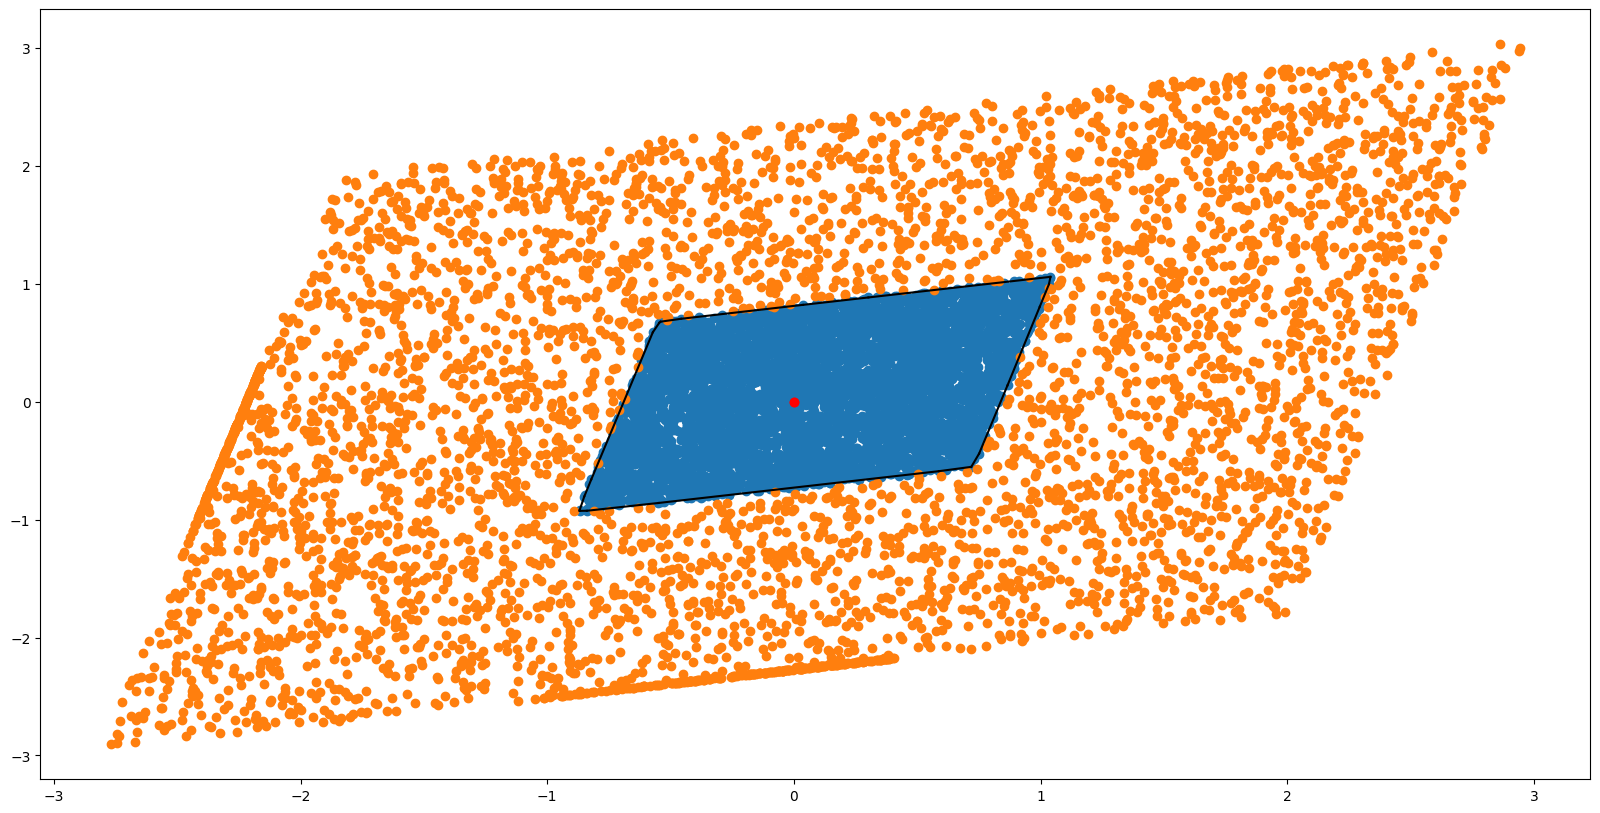

In [23]:
# normalisation included in the first layer of the network

mean_inp = torch.mean(included_space, dim=0)
mean_amp = torch.mean(ambient_space, dim=0)
mean = (mean_amp + mean_inp) / 2
print("mean {}, mean_inc {}, mean_amb {}".format(mean, mean_inp, mean_amp))

mean = mean.detach().requires_grad_(True)

std_inp = torch.std(included_space, dim=0)
std_amp = torch.std(ambient_space, dim=0)
std = (std_amp + std_inp) / 2 # todo std kann man nicht mitteln, inc und amb haben unterschiedliche std
print("std {}, std_inc {}, std_amb {}".format(std, std_inp, std_amp))
std = std.detach().requires_grad_(True)

ambient_space_transform = tv.transforms.Lambda(lambda x: (x - mean)/std)(ambient_space)
included_space_transform = tv.transforms.Lambda(lambda x: (x - mean)/std)(included_space) #todo nimmt der teilt der vectoren elementwise?

included_space_transform = included_space_transform.detach().requires_grad_(True)
ambient_space_transform = ambient_space_transform.detach().requires_grad_(True)

dataset = ConvexDataset(data=included_space_transform)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataset = ConvexDataset(data=ambient_space_transform)
ambient_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

plots = Plots_for(0, icnn, included_space_transform.detach(), ambient_space_transform.detach(), true_extremal_points, x_range, y_range)
plots.plt_initial()





=== Epoch: 0===
batch = 0, mean loss = 0.5008156884670178
batch = 100, mean loss = 1.3105561715758023
batch = 200, mean loss = 1.305238223048031
batch = 300, mean loss = 1.2649832350386059
batch = 400, mean loss = 1.228402699618131
batch = 500, mean loss = 1.190842556248287
batch = 600, mean loss = 1.1520694506575972
batch = 700, mean loss = 1.1285766184604977
batch = 800, mean loss = 1.110289329479807
batch = 900, mean loss = 1.081987056684061
batch = 1000, mean loss = 1.05538364313751
batch = 1100, mean loss = 1.0308328848610415
batch = 1200, mean loss = 1.0078853198099187
batch = 1300, mean loss = 0.9821995015132489
batch = 1400, mean loss = 0.957373035245403
batch = 1500, mean loss = 0.936312749320194
batch = 1600, mean loss = 0.9081776586030039
batch = 1700, mean loss = 0.8839861178232401
batch = 1800, mean loss = 0.8618050164477187
batch = 1900, mean loss = 0.8410481456161035
batch = 2000, mean loss = 0.818172810151368
batch = 2100, mean loss = 0.8006029854461365
batch = 2200, me

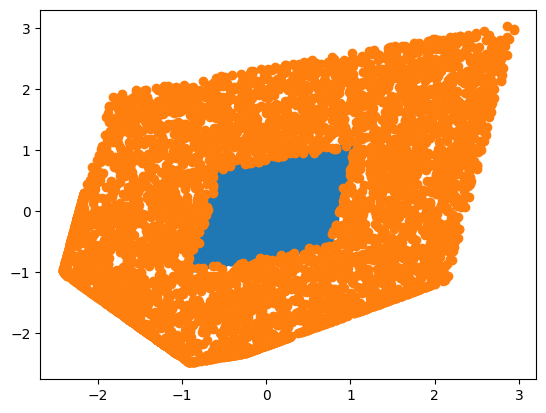

In [24]:
train_sequential_2(icnn, train_loader, ambient_loader, epochs=epochs)
plot_2d(icnn, included_space_transform, ambient_space_transform)

In [34]:
test_sequential(icnn, train_loader, ambient_loader)


dataset = ConvexDataset(data=included_space)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataset = ConvexDataset(data=ambient_space)
ambient_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

second_nn.load_state_dict(icnn.state_dict())

"""parameter_list = list(second_nn.parameters())
W = parameter_list[0]
b = parameter_list[1]
print(W)
print(b)"""
print("")
print(std.detach().numpy())
print(mean.detach().numpy())
print("")
with torch.no_grad():
    parameter_list = list(second_nn.parameters())
    parameter_list[0].data = torch.div(parameter_list[0], std)
    parameter_list[1].data = torch.add(- torch.matmul(parameter_list[0], mean), parameter_list[1])

"""W = parameter_list[0]
b = parameter_list[1]
print(W)
print(b)"""
test_sequential(second_nn, train_loader, ambient_loader)

[[ 0.57525231  0.58282511]
 [-0.34249625  0.67952469]]
[1.97502743 1.49614517]
test run 5000 iterations,  with mean loss = 0.0024097922984646076

[0.0009382  0.00088415]
[1.07303899 1.01860971]

[[ 613.14298243  659.19600646]
 [-365.05575995  768.56668839]]
[-1327.4147547   -389.65428333]
test run 5000 iterations,  with mean loss = 1.8986721394253971


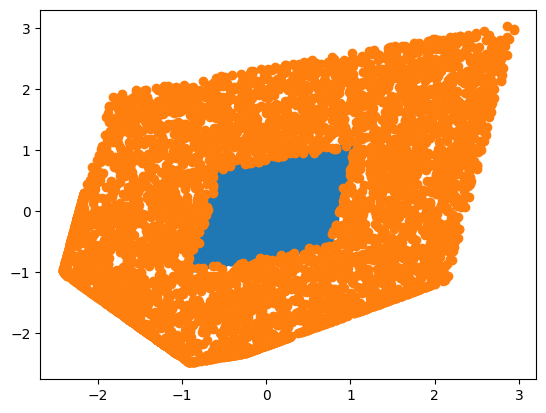

In [35]:
plot_2d(second_nn, included_space, ambient_space)

In [30]:
#normalisation applied on data previously

mean_inp = torch.mean(included_space, dim=0)
mean_amp = torch.mean(ambient_space, dim=0)
mean = (mean_amp + mean_inp) / 2
print("mean {}, mean_inc {}, mean_amb {}".format(mean, mean_inp, mean_amp))

mean = mean.detach().requires_grad_(True)

std_inp = torch.std(included_space, dim=0)
std_amp = torch.std(ambient_space, dim=0)
std = (std_amp + std_inp) / 2
print("std {}, std_inc {}, std_amb {}".format(std, std_inp, std_amp))
std = std.detach().requires_grad_(True)

ambient_space_transform = tv.transforms.Lambda(lambda x: 2000 * (x - mean))(ambient_space)
included_space_transform = tv.transforms.Lambda(lambda x: 2000 * (x - mean))(included_space)

#ambient_space = tv.transforms.Normalize(0, 1)(ambient_space)
#included_space = tv.transforms.Normalize(0, 1)(included_space)

ambient_space_transform = ambient_space_transform.clone().detach().requires_grad_(True)
included_space_transform = included_space_transform.clone().detach().requires_grad_(True)

dataset = ConvexDataset(data=included_space_transform)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataset = ConvexDataset(data=ambient_space_transform)
ambient_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


mean tensor([1.0730, 1.0186], dtype=torch.float64, grad_fn=<DivBackward0>), mean_inc tensor([1.0731, 1.0187], dtype=torch.float64, grad_fn=<MeanBackward1>), mean_amb tensor([1.0730, 1.0186], dtype=torch.float64, grad_fn=<MeanBackward1>)
std tensor([0.0009, 0.0009], dtype=torch.float64, grad_fn=<DivBackward0>), std_inc tensor([0.0004, 0.0004], dtype=torch.float64, grad_fn=<StdBackward0>), std_amb tensor([0.0014, 0.0013], dtype=torch.float64, grad_fn=<StdBackward0>)


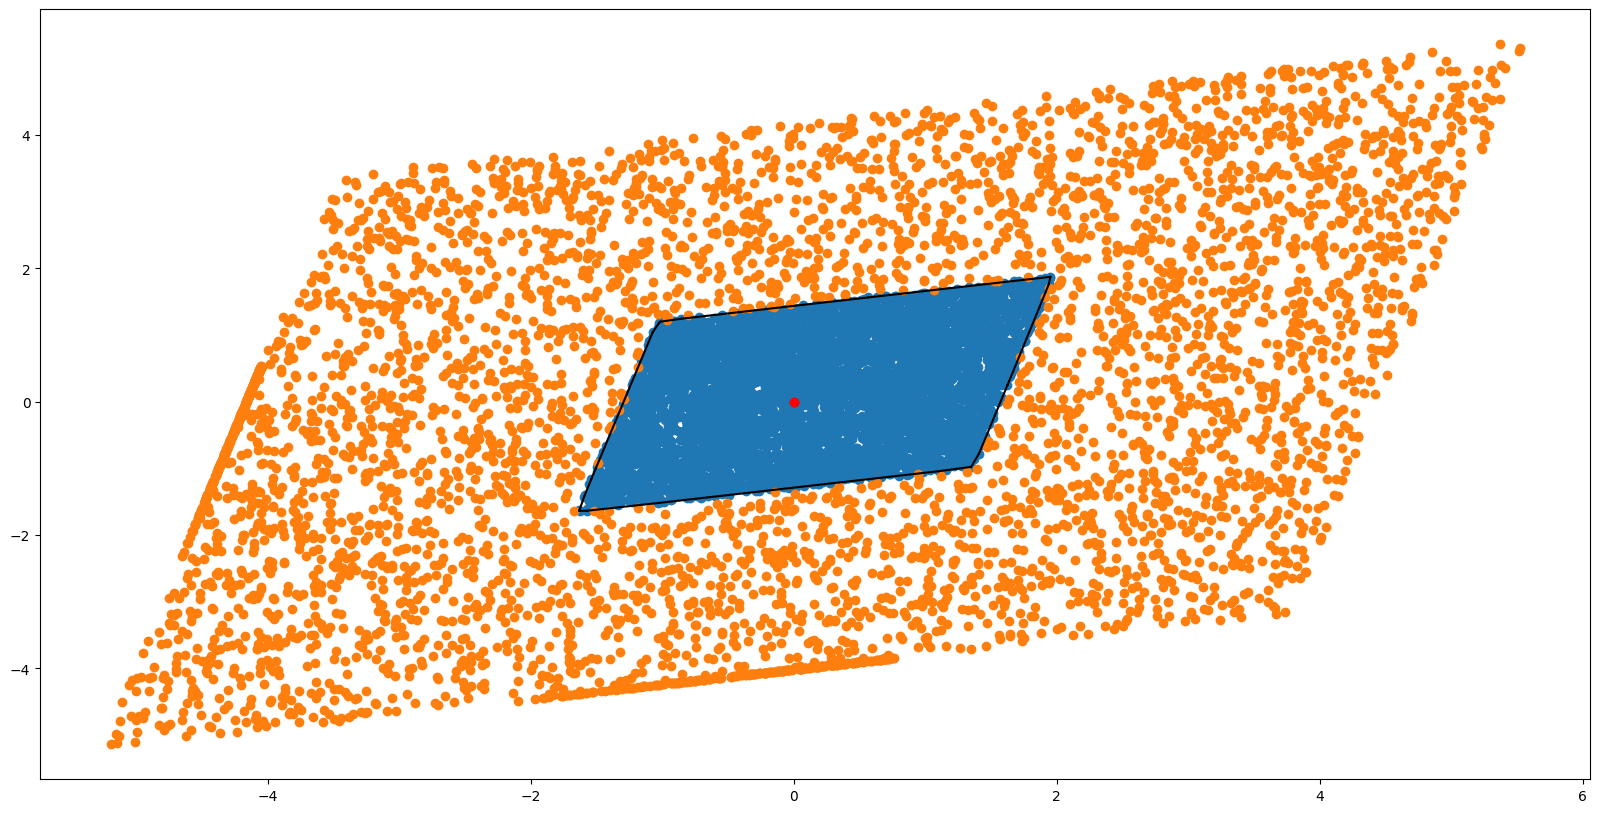

In [31]:
plots = Plots_for(0, icnn, included_space_transform.detach(), ambient_space_transform.detach(), true_extremal_points,
                  x_range, y_range)
plots.plt_initial()


In [ ]:
history = train_icnn(icnn, train_loader, ambient_loader, epochs=epochs, hyper_lambda=hyper_lambda)

In [1]:
plots.plt_mesh()

NameError: name 'plots' is not defined